In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
import scipy.stats as stats

# Reflect Tables into SQLAlchemy ORM

In [2]:
# Vacation dates

beg = '7/8/2020'
end = '7/22/2020'

In [3]:
# Creating the database engine

path = '/Users/noahsuskin/desktop/RU-JER-DATA-PT-04-2020-U-C/Homework/10-Advanced-Data-Storage-and-Retrieval/Instructions/Resources/hawaii.sqlite'
engine = create_engine(f"sqlite:///{path}")
session = Session(engine)

In [4]:
# Finding the names of the objects in the database

Base = automap_base()
Base.prepare(engine, reflect=True)
Base.classes.keys()

['measurement', 'station']

In [5]:
# Viewing the measurement object layout

measurement = Base.classes.measurement
meas_first_row = session.query(measurement).first().__dict__
meas_first_row

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x7fe49c927490>,
 'date': '2010-01-01',
 'tobs': 65.0,
 'prcp': 0.08,
 'id': 1,
 'station': 'USC00519397'}

In [6]:
# Viewing the station object layout

station = Base.classes.station
station_first_row = session.query(station).first().__dict__
station_first_row

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x7fe49c92f090>,
 'station': 'USC00519397',
 'latitude': 21.2716,
 'longitude': -157.8168,
 'id': 1,
 'name': 'WAIKIKI 717.2, HI US',
 'elevation': 3.0}

In [7]:
# Creating the connection between the database and python

conn = engine.connect()

# Climate Analysis

In [8]:
# Precipitaion Analysis

# Getting the latest date in the database
max_date = session.query(func.max(measurement.date)).all()
max_date

[('2017-08-23')]

In [9]:
# Extracting the date

start_date_lst = max_date[0][0].split('-')
start_date_year = start_date_lst[0]

start_date_month = start_date_lst[1]
if start_date_month[0] == '0':
    start_date_month = start_date_month.replace('0', '')


start_date_day = start_date_lst[2]
if start_date_day[0] == '0':
    start_date_day = start_date_day.replace('0', '')



In [10]:
# Precipitation Analysis

# Getting the start date of the past 12 months of data
start_date = dt.date(int(start_date_year),int(start_date_month),int(start_date_day)) - dt.timedelta(days=365)

# Creating df
query = session.query(measurement.date, measurement.prcp).filter(measurement.date >= start_date).all()
precipiation_df = pd.DataFrame(query, columns=['date', 'precipitation'])
precipiation_df.head()


,date,precipitation
0,2016-08-23,0.00
1,2016-08-24,0.08
2,2016-08-25,0.08
3,2016-08-26,0.00
4,2016-08-27,0.00


In [11]:
# Precipitaion Analysis

# Modifying and Cleaning the df
precipiation_df = precipiation_df.groupby(['date']).sum()
precipiation_df = precipiation_df.sort_index()
precipiation_df.head()

,precipitation
date,
2016-08-23,2.71
2016-08-24,9.33
2016-08-25,0.54
2016-08-26,0.10
2016-08-27,0.32


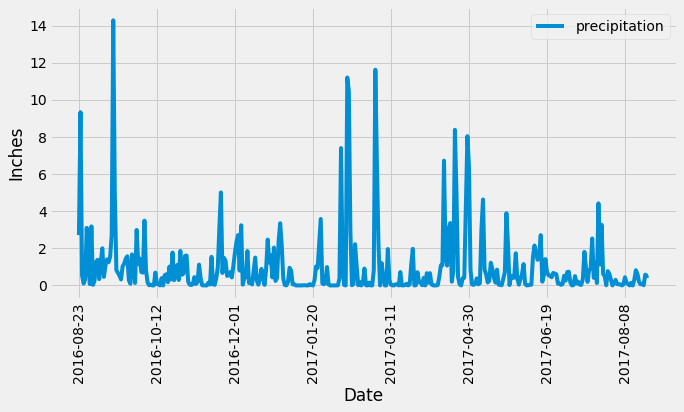

In [12]:
# Precipitaion Analysis

# Plotting the df
precipiation_df.plot(figsize=(10,5))
plt.xticks(rotation=90)
plt.xlabel('Date')
plt.ylabel('Inches')
plt.show()

In [13]:
# Precipitaion Analysis

# Summary Statistics
precipiation_df.describe()

,precipitation
count,366.000000
mean,0.978907
std,1.776349
min,0.000000
25%,0.052500
50%,0.405000
75%,1.087500
max,14.280000


# Station Analysis

In [14]:
# Station Analysis

# Calculating the total number of stations
num_of_stations = session.query(func.count(station.id)).all()[0]
num_of_stations

(9)

In [15]:
# Station Analysis

# Listing the stations name, station, and number of observations
stations_count = session.query(station.name, measurement.station, func.count(measurement.station))\
    .group_by(measurement.station)\
    .filter(station.station == measurement.station)\
    .order_by(func.count(measurement.station).desc())\
    .all()
stations_count

[('WAIHEE 837.5, HI US', 'USC00519281', 2772),
 ('WAIKIKI 717.2, HI US', 'USC00519397', 2724),
 ('KANEOHE 838.1, HI US', 'USC00513117', 2709),
 ('WAIMANALO EXPERIMENTAL FARM, HI US', 'USC00519523', 2669),
 ('MANOA LYON ARBO 785.2, HI US', 'USC00516128', 2612),
 ('KUALOA RANCH HEADQUARTERS 886.9, HI US', 'USC00514830', 2202),
 ('HONOLULU OBSERVATORY 702.2, HI US', 'USC00511918', 1979),
 ('PEARL CITY, HI US', 'USC00517948', 1372),
 ('UPPER WAHIAWA 874.3, HI US', 'USC00518838', 511)]

In [16]:
# Station Analysis

# Station with the highest number of observations
highest_station = session.query(station.name, measurement.station, func.count(measurement.station))\
    .group_by(measurement.station)\
    .filter(station.station == measurement.station)\
    .order_by(func.count(measurement.station).desc())\
    .limit(1)\
    .all()
highest_station

[('WAIHEE 837.5, HI US', 'USC00519281', 2772)]

In [17]:
# Station Analysis

# Station with the highest number of observations within the past 12 months
highest_station_12_month = session.query(station.name, measurement.station, func.count(measurement.station))\
    .group_by(measurement.station)\
    .filter(station.station == measurement.station)\
    .filter(measurement.date >= start_date)\
    .order_by(func.count(measurement.station).desc())\
    .limit(1)\
    .all()
highest_station_12_month

[('WAIKIKI 717.2, HI US', 'USC00519397', 361)]

In [18]:
# Station Analysis

# Hard coding the station from the previous query
highest_station_name = highest_station_12_month[0][1]

# Getting data from last 12 months
station_df = session.query(measurement.date, measurement.tobs, measurement.station)\
    .filter(measurement.date >= start_date)\
    .filter(measurement.station == highest_station_name)\
    .all()
station_df

[('2016-08-23', 81.0, 'USC00519397'),
 ('2016-08-24', 79.0, 'USC00519397'),
 ('2016-08-25', 80.0, 'USC00519397'),
 ('2016-08-26', 79.0, 'USC00519397'),
 ('2016-08-27', 77.0, 'USC00519397'),
 ('2016-08-28', 78.0, 'USC00519397'),
 ('2016-08-29', 78.0, 'USC00519397'),
 ('2016-08-30', 79.0, 'USC00519397'),
 ('2016-08-31', 80.0, 'USC00519397'),
 ('2016-09-01', 81.0, 'USC00519397'),
 ('2016-09-02', 80.0, 'USC00519397'),
 ('2016-09-03', 79.0, 'USC00519397'),
 ('2016-09-04', 75.0, 'USC00519397'),
 ('2016-09-05', 79.0, 'USC00519397'),
 ('2016-09-06', 76.0, 'USC00519397'),
 ('2016-09-07', 76.0, 'USC00519397'),
 ('2016-09-08', 80.0, 'USC00519397'),
 ('2016-09-09', 79.0, 'USC00519397'),
 ('2016-09-10', 78.0, 'USC00519397'),
 ('2016-09-11', 76.0, 'USC00519397'),
 ('2016-09-12', 78.0, 'USC00519397'),
 ('2016-09-13', 78.0, 'USC00519397'),
 ('2016-09-14', 75.0, 'USC00519397'),
 ('2016-09-15', 79.0, 'USC00519397'),
 ('2016-09-16', 80.0, 'USC00519397'),
 ('2016-09-17', 79.0, 'USC00519397'),
 ('2016-09-1

In [19]:
# Station Analysis

# Putting the query into a df
highest_station_df = pd.DataFrame(station_df, columns=['date', 'tobs', 'station'])
highest_station_df.head()

,date,tobs,station
0,2016-08-23,81.0,USC00519397
1,2016-08-24,79.0,USC00519397
2,2016-08-25,80.0,USC00519397
3,2016-08-26,79.0,USC00519397
4,2016-08-27,77.0,USC00519397


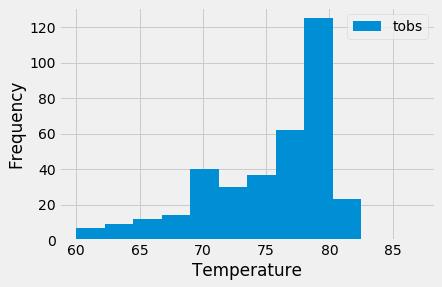

In [20]:
# Station Analysis

# Plotting the df
temp_plot = highest_station_df['tobs']
temp_plot.plot.hist(bins=12)
plt.xlabel('Temperature')
plt.legend()
plt.show()

# Bonus Analysis

In [21]:
# Bonus Analysis

# Creating dataframes using the csv files
measurements_path = '../RU-JER-DATA-PT-04-2020-U-C/Homework/10-Advanced-Data-Storage-and-Retrieval/Instructions/Resources/hawaii_measurements.csv'
station_path = '../RU-JER-DATA-PT-04-2020-U-C/Homework/10-Advanced-Data-Storage-and-Retrieval/Instructions/Resources/hawaii_stations.csv'

measurements_dataframe = pd.read_csv(measurements_path)
station_dataframe = pd.read_csv(station_path)
measurements_dataframe.head()

,station,date,prcp,tobs
0,USC00519397,2010-01-01,0.08,65
1,USC00519397,2010-01-02,0.00,63
2,USC00519397,2010-01-03,0.00,74
3,USC00519397,2010-01-04,0.00,76
4,USC00519397,2010-01-06,NaN,73


In [22]:
# Bonus Analysis

# Average June temp
june = '06'
june_data = session.query(measurement.date, measurement.tobs)\
    .filter(func.strftime("%m", measurement.date) == june).all()
june_df = pd.DataFrame(june_data, columns=['date', 'tobs'])
june_average = june_df['tobs'].mean()
june_average

74.94411764705882

In [23]:
# Bonus Analysis - Temperature Analysis 1

# Average December temp
december = '12'
december_data = session.query(measurement.date, measurement.tobs)\
    .filter(func.strftime("%m", measurement.date) == december).all()
december_df = pd.DataFrame(december_data, columns=['date', 'tobs'])
december_average = december_df['tobs'].mean()
december_average

71.04152933421226

In [24]:
# Bonus Analysis - Temperature Analysis 1

# Running a 1sample ttest to see if there is a signifigance difference in means
# Used a 1 sample ttest becasue we are comparing the same island of hawaii but with differenet time frames
# pvalue suggests that the difference in means is statistically signifigant
ttest = stats.ttest_1samp(december_df['tobs'], june_average)
ttest

Ttest_1sampResult(statistic=-40.5776649801089, pvalue=2.482878606222954e-244)

In [25]:
# Bonus Analysis - Temperature Analysis 2

# Using the function
def calc_temps(start_date, end_date):
    
    return session.query(func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)).\
        filter(measurement.date >= start_date).filter(measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


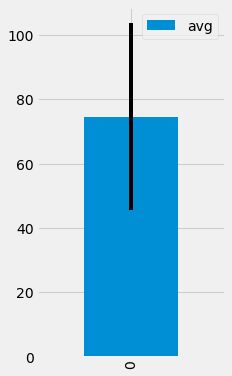

In [26]:
# Bonus Analysis - Temperature Analysis 2
# Plotting results

stats = calc_temps('2016-08-23', '2017-08-23')
rain_stats_df = pd.DataFrame(stats, columns=['min', 'avg', 'max'])
yerr_value_calc = rain_stats_df['max'].values - rain_stats_df['min'].values
yerr_value = yerr_value_calc[0]
rain_stats_df.plot(kind='bar', y='avg', yerr=yerr_value, figsize=(3,6))
plt.show()